# Preliminary installs and imports

Each individual function is displayed with a test example, please scroll to the bottom to see the final automated function. Please check the current display output first as in order to make the automated function work, many print statements/imshows have been commented out. Uncomment where I have suggested in order to see a test example at each stage if there is no display saved in the notebook, or if you wish to re-run.

Please note: the images were loaded in alphabetically, so they are not in the same order as the folder shows. Please see the call of getFiles() to see the order I used if relevant.

In [179]:
#pip install opencv-python

In [180]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import operator
import itertools

# Loading Images

In [148]:
#note that i created this notebook in the same path as the image folder
#if you did not change the last line to images.append(os.path.join(path, file)) and pass your path as an arg to function
#and listdir

def getFiles():
    #imports all png files in filepath
    images=[]
    for file in os.listdir():
        if file.endswith(".png"):
            images.append(file)
    return images

In [149]:
images = getFiles()
images

['noise_1.png',
 'noise_2.png',
 'noise_3.png',
 'noise_4.png',
 'noise_5.png',
 'org_1.png',
 'org_2.png',
 'org_3.png',
 'org_4.png',
 'org_5.png',
 'proj1_1.png',
 'proj1_2.png',
 'proj1_3.png',
 'proj1_4.png',
 'proj1_5.png',
 'proj2_1.png',
 'proj2_2.png',
 'proj2_3.png',
 'proj2_4.png',
 'proj2_5.png',
 'proj_1.png',
 'proj_2.png',
 'proj_3.png',
 'proj_4.png',
 'proj_5.png',
 'rot_1.png',
 'rot_2.png',
 'rot_3.png',
 'rot_4.png',
 'rot_5.png']

In [150]:
def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    #cv2 actually reads in bgr colourspace so need to reverse to ensure same image as folder
    return image

In [151]:
def loader(images): #images should be a list of file names i.e from getFiles()
    img_arrays = []

    for i in images:
        res = load_image(i)
        img_arrays.append(res)
        
    return img_arrays

In [152]:
img_arrays = loader(images)

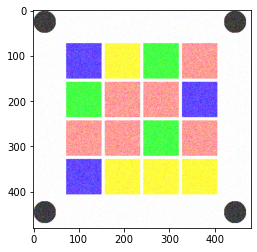

In [153]:
plt.imshow(img_arrays[0]) #test display

# Finding Colours

In [162]:
img_arrays = loader(images) #while testing, call this before every test as image will change

In [189]:
def finding_squares(img,thr):
    img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
    gray = cv2.GaussianBlur(gray,(3,3),0) #eliminate some of the noise
    thresh = cv2.threshold(gray, thr,255, cv2.THRESH_BINARY_INV)[1] #th passed in order to test best threshold range
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    #RETR_EXTERNAL ignores contours within contours, so hopefully gets rid of noisy blocks
    #CHAIN_APPROX_SIMPLE decreases the number of points in the contours so decreases computation
    
    cv2.drawContours(img, contours, -1, (255,0,0), 3) #uncomment to see contours on the image
    
    square_coords = []
    
    #taken from opencv docs: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
    for c in contours:
        M = cv2.moments(c) #useful moment calculator from opencv
        #if the moment is 0, the contour is probably noise as it has no real shape
        #we eliminated most of this using ret_external, but this will catch other noise, if any
        if M['m00'] != 0:
            cX = int(M['m10'] / M['m00']) #centroid x coord
            cY = int(M['m01'] / M['m00']) #centroid y coor
            
        else: #does not affect anything, just avoids math error
            cX, cY = 0, 0
            
        square_coords.append((cX, cY))
        #cv2.circle(img, (cX, cY), 5, (255,0,0), - 1) #plot the circles 
        plt.imshow(img)
        
    square_range = square_coords[2:-2] #the first and last two do include the circles (used later)
    
    #now return sorted set of unique coords
    return sorted(list(set(itertools.chain.from_iterable(square_range))))

[111, 196, 281, 366]

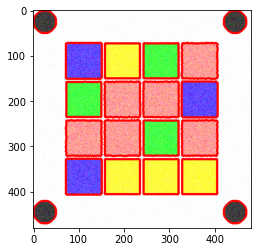

In [190]:
tile_coord = finding_squares(img_arrays[0],230)
tile_coord

In [169]:
image_arrays = loader(images)
def get_colours(img, search_area): #search area is the coords from finding_squares
    colours = [] #final results matrix
    img = cv2.GaussianBlur(img,(5,5),0) 
    #too much noise without this filter when detecting colours
    #discovered after correlation, so report may vary slightly, but final accuracy good
    
    red_channel = img[:,:,0] #split image input into respective rgb channels
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    
    for i in search_area: #go to x and y centroid locations in grid
        for j in search_area:
            red_range = red_channel[i][j]
            gr_range = green_channel[i][j]
            bl_range = blue_channel[i][j]
            
            #colour troubleshooting (uncomment to see rgb vals in tile)
            #print(red_range)
            #print(gr_range)
            #print(bl_range)
            
        #https://www.rapidtables.com/web/color/RGB_Color.html (for RGB references)
        #note these values are very specific to the image set, may not work fully on other sets
            if red_range > 250 and gr_range > 250 and bl_range > 250:
                colours.append('w') #double check it isn't catching the background or inbetween space
            elif red_range > 200 and gr_range > 189 : #I didnt account for orange at first, so very specific
                #a bit trickier because some 'yellow' shades are questionable/green looking
                #yellow statement must come first otherwise it will catch as red
                colours.append('y')
            elif gr_range > 102 and bl_range < 210 and red_range < 210 :
                colours.append('g')
            elif bl_range > 102 and red_range < 210: #some very light greens had high red
                colours.append('b')
            elif red_range > 201: #some cyan looking colours have very high green but id consider it blue
                colours.append('r')
            else:
                colours.append('unk') #checks for missed RGB ranges
    
    #plt.imshow(img)  #uncomment to compare with matrix
    
    return np.array(colours).reshape((4,4)) #get in the square 4x4 format

[['y' 'r' 'r' 'g']
 ['y' 'g' 'g' 'y']
 ['g' 'g' 'y' 'b']
 ['y' 'y' 'r' 'r']]


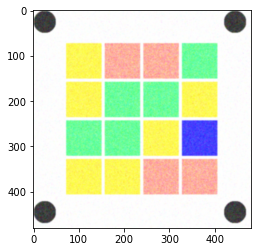

In [172]:
print(get_colours(img_arrays[1],tile_coord)) #test: all correct for all org and noise (see report)

# Finding Circles

In [173]:
img_arrays = loader(images)

In [236]:
# # tester display cell #left in case you wish to see thresholding output
# img_arrays = loader(images)
# kernel_size = 3
# gray = cv2.cvtColor(img_arrays[12], cv2.COLOR_RGB2GRAY)
# blur = cv2.medianBlur(gray,kernel_size)
# blur = cv2.GaussianBlur(blur, (kernel_size,kernel_size),0)
# min_pix = min(blur.flatten()) #returns minimum pixel, or darkest colour (black circles)
# #tried with just this blur to reduce noise at first but wasn't very good, see report
# thresh = cv2.threshold(blur, (min_pix + 46),255, cv2.THRESH_BINARY)[1] #56
# #BINARY_INV will keep black, BINARY keeps white
# thresh = cv2.erode(thresh, None, iterations = 2)
# thresh = cv2.dilate(thresh, None, iterations = 2)
# plt.imshow(thresh,cmap = 'gray')
# # find contours in thresholded image, then grab the largest
# # one
# ##plus 30 to whatever the minimum is and we get good thresholding

In [174]:
img_arrays = loader(images)

In [183]:
#some noise filtering taken from https://towardsdatascience.com/image-filters-in-python-26ee938e57d2
#see comments of 'def finding_squares' for further information

def find_circles(img, th):
    kernel_size = 3 #vary if bad performance
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    blur = cv2.medianBlur(gray,kernel_size) #two different filters worked better
    blur = cv2.GaussianBlur(blur, (kernel_size,kernel_size),0)
    min_pix = min(blur.flatten()) #returns minimum pixel, or darkest colour (black circles)
    thresh = cv2.threshold(blur, (min_pix + th),255, cv2.THRESH_BINARY)[1] #threshold out everything that isnt black
    #BINARY_INV will keep black, BINARY keeps white
    thresh = cv2.erode(thresh, None, iterations = 2) #sharpen the remaining circles
    thresh = cv2.dilate(thresh, None, iterations = 2)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    #unsure why RETR_TREE worked better, would not have expected it to
    #plt.imshow(thresh) #uncomment this to see the thresholding
    centroid_coords = []
    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0: 
            cX = int(M['m10']/ M['m00'])
            cY = int(M['m01']/ M['m00'])
        else:
            cX, cY = 0, 0
            
        if cX and cY > 0: 
            #the 0 cX and cY is just a way to avoid math errors, they don't mean anything but we dont want them
            centroid_coords.append((cX,cY))
        
        cv2.circle(img, (cX, cY), 5, (0, 200, 250), -1)
        #plt.imshow(img) #uncomment to see where circles have been located
    
    #if 4 sets of co-ordinates have not been found, this will break, so try...except needed for automation
    try:
        p1,p2,p3,p4 = centroid_coords[1], centroid_coords[2], centroid_coords[-2], centroid_coords[-1]
        br,bl,tr,tl = tuple(),tuple(),tuple(),tuple()

        #without this image24 was wrapping around itself (see report)
        if p1[0] > p2[0]:# and p1[1] > p2[1]:
            br += p1
            bl += p2
        else: 
            bl += p1
            br += p2
        if p4[0] > p3[0]:
            tr += p4
            tl += p3
        else:
            tl += p4
            tr += p3

        coords = [br,bl,tr,tl] 
        #bottom right, top right etc (doesnt neccessarily correspond to that location with rotation images)
        return coords
        
    except:
        print("Not enough circles detected to be a valid solution")
    

[(401, 609), (40, 396), (613, 247), (252, 35)]

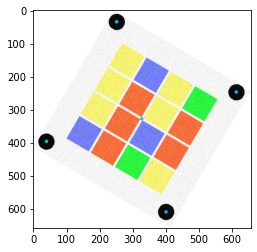

In [184]:
#check plt.imshow uncommented first
img_arrays = loader(images)
find_circles(img_arrays[29],30)
#max,max br, min, max bl, max min tr, min,min tl

# Image Correction

In [185]:
#using img_arrays[5], i.e orig_1 as the reference points
img_arrays = loader(images)
def corrected(img):
    img_arrays = loader(images)
    img1 = img.copy()
    corr_coords = np.float32(find_circles(img_arrays[5],30)) #turns list of tuples into (4,2) matrix #was 35 before
    curr_coords = np.float32(find_circles(img,30)) #30 was found to be good addition to thresh
    #float32 allows greater precision
    correction_matrix = cv2.getPerspectiveTransform((curr_coords), (corr_coords)) 
    #gets vector map of current coords to goal coords
    corr_img = cv2.warpPerspective(img1, correction_matrix, (480,480)) 
    #does the transform and accounts for scaled images
    #flipped =  cv2.flip(corr_img, 1) #uncomment/comment if image is flipped. change 1 to 0 if flipped about y
    plt.imshow(corr_img) #change to corr_img if you comment out above
    
    #return flipped if you want flipped
    return np.array(corr_img)

array([[[254, 240, 254],
        [244, 247, 251],
        [248, 246, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[238, 247, 250],
        [247, 244, 239],
        [249, 247, 247],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[247, 246, 239],
        [249, 246, 247],
        [242, 235, 251],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[244, 246, 237],
        [247, 245, 245],
        [248, 238, 246],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[249, 247, 247],
        [250, 241, 247],
        [251, 242, 250],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[251, 245, 249],
        [252, 245, 251],
        [251, 231, 253],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

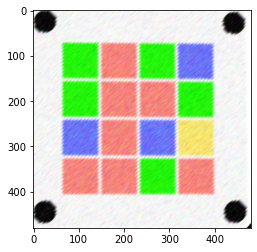

In [187]:
corrected(img_arrays[11])

# Automated Function

In [144]:
def solution():
    #add filepath as argument to main and first line if you did not put in same folder
    images = getFiles() #returns sorted (alphabetical) list of image files
    img_arrays = loader(images) #numerical arrays of images
    square_coords = finding_squares(img_arrays[0],230) #get coordinates of each tile
    #^ 230 is specific to the noisy images, may need to change threshold for others (e.g. org)
       
    for image,name in zip(img_arrays,images):
        print(name) #current image
        orig = image.copy()
        corrected_image = corrected(image) #undistort the image
        colour_matrix = get_colours(corrected_image,square_coords) #then get colours
        print(colour_matrix)
        
        #compare original images and fixed images
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.subplot(1,2,2)
        plt.imshow(corrected_image)
        plt.show()
        print()

noise_1.png
[['b' 'y' 'g' 'r']
 ['g' 'r' 'r' 'b']
 ['r' 'r' 'g' 'r']
 ['b' 'y' 'y' 'y']]


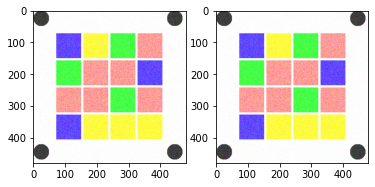


noise_2.png
[['y' 'r' 'r' 'g']
 ['y' 'g' 'g' 'y']
 ['g' 'g' 'y' 'b']
 ['y' 'y' 'r' 'r']]


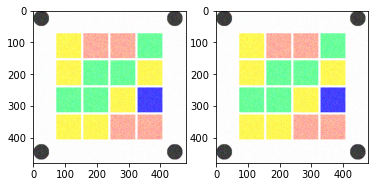


noise_3.png
[['b' 'r' 'r' 'b']
 ['y' 'y' 'b' 'y']
 ['r' 'y' 'r' 'g']
 ['y' 'b' 'g' 'b']]


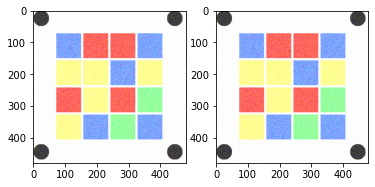


noise_4.png
[['r' 'y' 'b' 'r']
 ['y' 'b' 'y' 'g']
 ['g' 'g' 'r' 'g']
 ['g' 'y' 'y' 'b']]


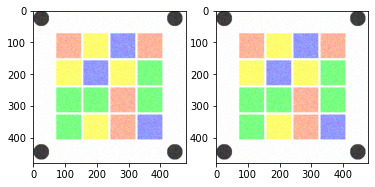


noise_5.png
[['y' 'g' 'y' 'b']
 ['b' 'b' 'g' 'r']
 ['r' 'b' 'g' 'g']
 ['y' 'y' 'y' 'g']]


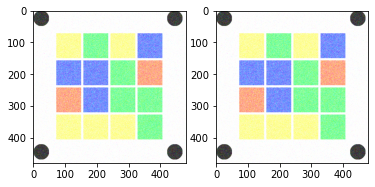


org_1.png
[['y' 'g' 'b' 'b']
 ['r' 'r' 'y' 'r']
 ['b' 'g' 'b' 'b']
 ['r' 'g' 'r' 'b']]


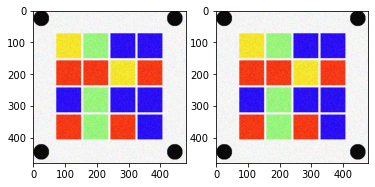


org_2.png
[['r' 'b' 'y' 'b']
 ['b' 'b' 'y' 'y']
 ['g' 'b' 'b' 'g']
 ['y' 'g' 'y' 'r']]


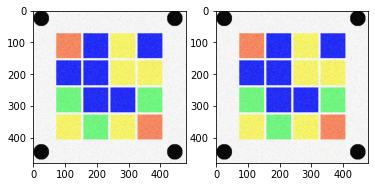


org_3.png
[['b' 'b' 'y' 'g']
 ['g' 'r' 'y' 'b']
 ['r' 'g' 'y' 'b']
 ['r' 'g' 'b' 'b']]


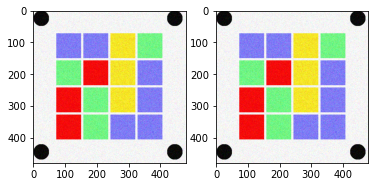


org_4.png
[['b' 'r' 'r' 'b']
 ['r' 'b' 'r' 'y']
 ['b' 'g' 'g' 'g']
 ['r' 'r' 'y' 'r']]


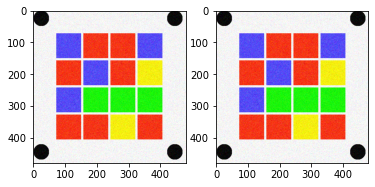


org_5.png
[['r' 'g' 'r' 'r']
 ['g' 'g' 'g' 'b']
 ['g' 'g' 'b' 'y']
 ['r' 'r' 'b' 'b']]


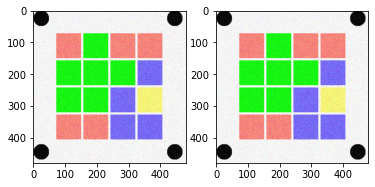


proj1_1.png
[['r' 'r' 'y' 'b']
 ['y' 'y' 'g' 'r']
 ['b' 'g' 'r' 'y']
 ['b' 'y' 'y' 'b']]


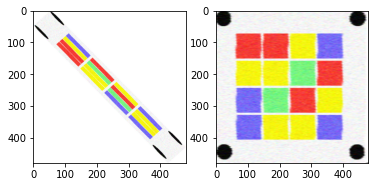


proj1_2.png
[['g' 'r' 'g' 'b']
 ['g' 'r' 'r' 'g']
 ['b' 'r' 'b' 'y']
 ['r' 'r' 'g' 'r']]


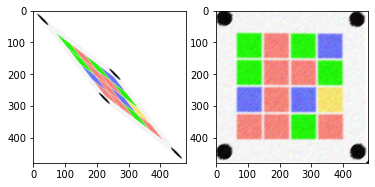


proj1_3.png
[['g' 'b' 'y' 'b']
 ['y' 'b' 'y' 'b']
 ['g' 'r' 'y' 'y']
 ['y' 'b' 'g' 'y']]


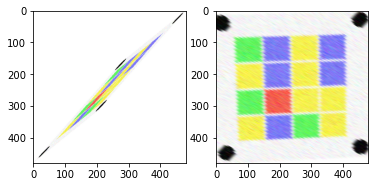


proj1_4.png
[['b' 'g' 'y' 'y']
 ['r' 'r' 'y' 'r']
 ['b' 'b' 'y' 'b']
 ['y' 'r' 'g' 'y']]


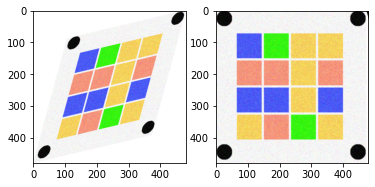


proj1_5.png
[['r' 'g' 'r' 'y']
 ['y' 'r' 'g' 'r']
 ['r' 'b' 'g' 'g']
 ['g' 'g' 'b' 'r']]


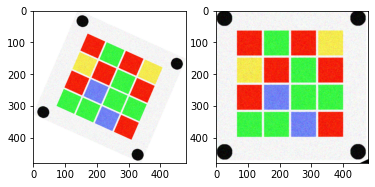


proj2_1.png
[['g' 'b' 'y' 'b']
 ['y' 'g' 'b' 'g']
 ['g' 'g' 'y' 'r']
 ['y' 'y' 'b' 'g']]


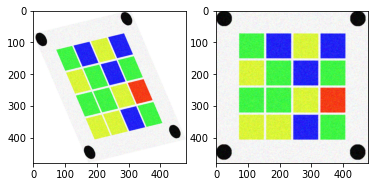


proj2_2.png
[['b' 'y' 'g' 'r']
 ['y' 'y' 'b' 'g']
 ['g' 'g' 'y' 'g']
 ['b' 'g' 'b' 'g']]


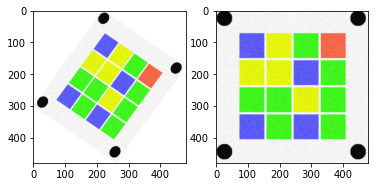


proj2_3.png
[['r' 'y' 'b' 'r']
 ['g' 'r' 'g' 'g']
 ['r' 'g' 'g' 'y']
 ['r' 'g' 'b' 'y']]


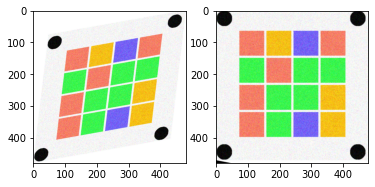


proj2_4.png
[['r' 'y' 'g' 'g']
 ['y' 'y' 'r' 'y']
 ['g' 'r' 'y' 'b']
 ['b' 'g' 'b' 'r']]


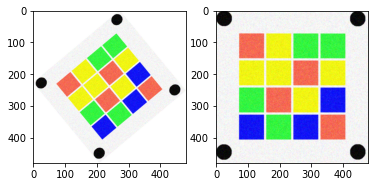


proj2_5.png
[['r' 'r' 'r' 'y']
 ['b' 'b' 'b' 'g']
 ['g' 'b' 'y' 'r']
 ['r' 'r' 'y' 'b']]


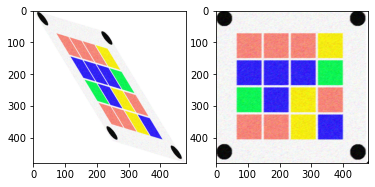


proj_1.png
[['y' 'g' 'g' 'y']
 ['y' 'y' 'g' 'b']
 ['r' 'b' 'b' 'g']
 ['b' 'g' 'g' 'y']]


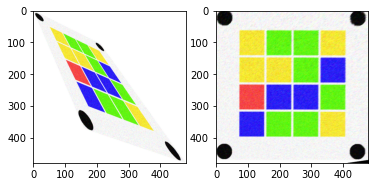


proj_2.png
[['b' 'b' 'b' 'b']
 ['r' 'r' 'g' 'b']
 ['y' 'y' 'y' 'g']
 ['g' 'b' 'y' 'g']]


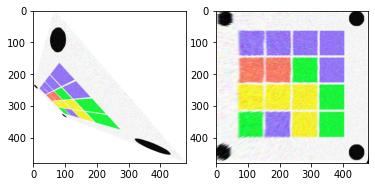


proj_3.png
[['r' 'r' 'g' 'r']
 ['r' 'y' 'g' 'g']
 ['b' 'b' 'b' 'g']
 ['r' 'b' 'y' 'y']]


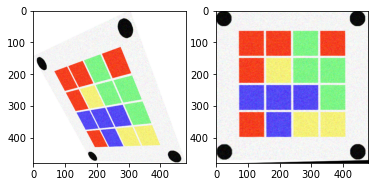


proj_4.png
[['g' 'r' 'b' 'b']
 ['y' 'g' 'r' 'y']
 ['r' 'g' 'r' 'y']
 ['r' 'g' 'y' 'b']]


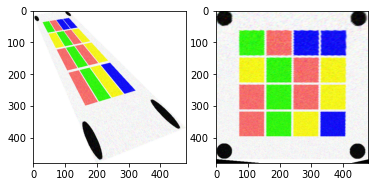


proj_5.png
[['y' 'g' 'b' 'r']
 ['y' 'y' 'r' 'g']
 ['b' 'b' 'y' 'y']
 ['y' 'y' 'b' 'y']]


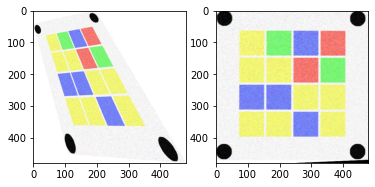


rot_1.png
[['r' 'g' 'y' 'y']
 ['b' 'y' 'y' 'y']
 ['g' 'g' 'y' 'r']
 ['g' 'r' 'r' 'r']]


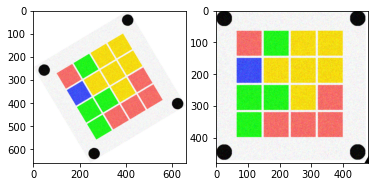


rot_2.png
[['g' 'y' 'r' 'r']
 ['r' 'r' 'b' 'b']
 ['g' 'b' 'b' 'y']
 ['b' 'y' 'b' 'y']]


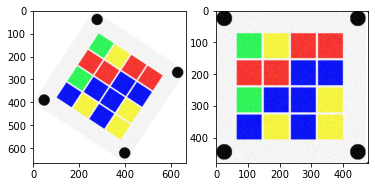


rot_3.png
[['r' 'b' 'b' 'r']
 ['r' 'b' 'r' 'b']
 ['y' 'b' 'y' 'b']
 ['r' 'b' 'b' 'b']]


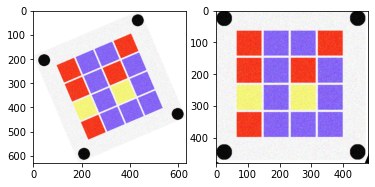


rot_4.png
[['g' 'y' 'y' 'b']
 ['b' 'g' 'g' 'y']
 ['y' 'y' 'b' 'b']
 ['g' 'g' 'y' 'r']]


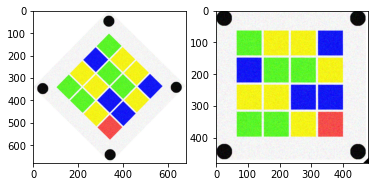


rot_5.png
[['y' 'b' 'y' 'g']
 ['y' 'r' 'y' 'r']
 ['y' 'r' 'b' 'r']
 ['b' 'r' 'g' 'y']]


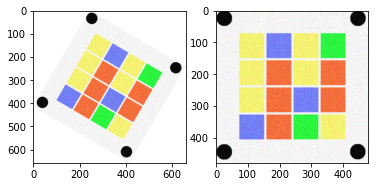

In [188]:
solution()